In [ ]:
## Prediction Movie Boxoffice Earnings

In [ ]:
##Problem:
## You have historical data about moive relese, including cast, genre and budget. How would you predict a moive box office performance?

In [2]:
## Step1 import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import accuracy_score, classification_report

In [3]:
## step 2 Data Collection

df = pd.read_csv('bollywood_box_clean.csv')
print(df.columns)
print(df.info())

print(df.head())

Index(['movie_name', 'movie_opening', 'movie_weekend', 'movie_firstweek',
       'movie_total', 'movie_total_worldwide', 'movie_genre', 'movie_director',
       'release_date', 'release_day', 'release_month', 'release_year',
       'runtime', 'producer', 'banner', 'actors', 'movie_details'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movie_name             130 non-null    object 
 1   movie_opening          130 non-null    float64
 2   movie_weekend          130 non-null    float64
 3   movie_firstweek        130 non-null    float64
 4   movie_total            130 non-null    float64
 5   movie_total_worldwide  130 non-null    float64
 6   movie_genre            129 non-null    object 
 7   movie_director         130 non-null    object 
 8   release_date           130 non-null    object 
 9   rel

In [5]:
# step3 Exploratory data analysis

#check null values
df.isnull().sum()

#drop the null values because those null values are object type
df.dropna(inplace=True)

#after clear null values
df.isnull().sum()

movie_name               0
movie_opening            0
movie_weekend            0
movie_firstweek          0
movie_total              0
movie_total_worldwide    0
movie_genre              0
movie_director           0
release_date             0
release_day              0
release_month            0
release_year             0
runtime                  0
producer                 0
banner                   0
actors                   0
movie_details            0
dtype: int64

In [6]:
## Split numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Display them
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)



Numerical columns: ['movie_opening', 'movie_weekend', 'movie_firstweek', 'movie_total', 'movie_total_worldwide', 'release_day', 'release_year', 'runtime']
Categorical columns: ['movie_name', 'movie_genre', 'movie_director', 'release_date', 'release_month', 'producer', 'banner', 'actors', 'movie_details']



Outliers in 'movie_opening':
     movie_opening
26           53.35
33           29.16
40           42.30
71           52.25
90           34.75
91           29.17
113          34.10
120          30.14

Outliers in 'movie_weekend':
     movie_weekend
26          166.25
40          150.10
71          123.00
90          120.06
91          106.47
109         114.00
113         114.93

Outliers in 'movie_firstweek':
     movie_firstweek
26            238.35
40            180.05
90            202.51
109           166.50
113           206.04

Outliers in 'movie_total':
     movie_total
11        276.90
26        318.01
38        278.24
90        341.22
109       300.26
113       339.16

Outliers in 'movie_total_worldwide':
     movie_total_worldwide
26                  455.00
31                  424.00
38                  369.58
67                  520.00
90                  579.00
109                 585.00
113                 558.00
121                 547.00

Outliers in 'release_day':
Emp

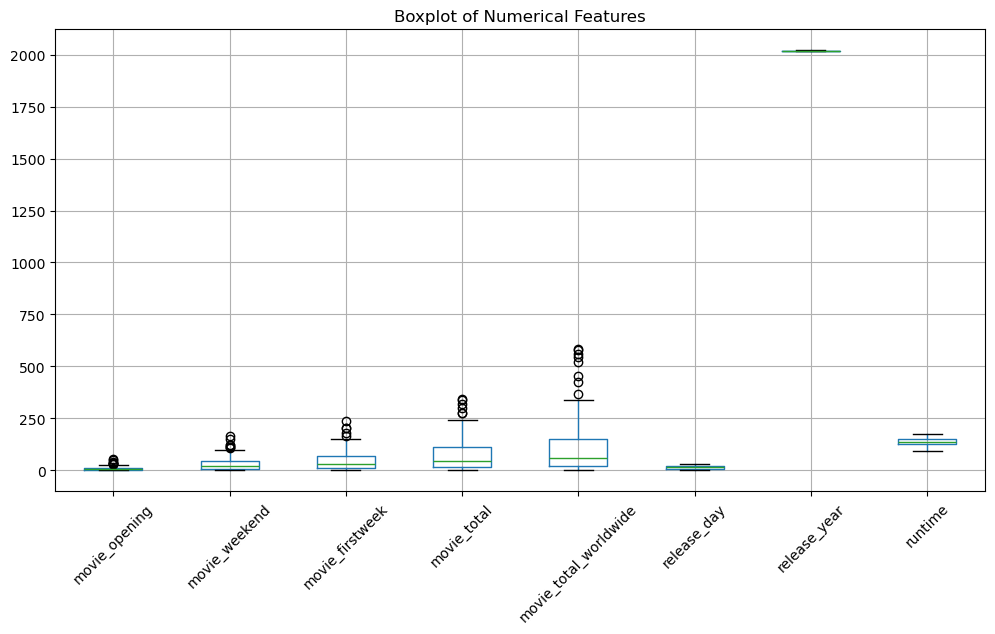

In [7]:
#check outliers 

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    print(f"\nOutliers in '{col}':")
    print(outliers[[col]])

#so based on result we no outliers 

import matplotlib.pyplot as plt

df[numerical_cols].boxplot(figsize=(12,6))
plt.title("Boxplot of Numerical Features")
plt.xticks(rotation=45)
plt.show()


In [8]:
## check correlations

corr_val=df[numerical_cols].corr()
print(corr_val)

                       movie_opening  movie_weekend  movie_firstweek  \
movie_opening               1.000000       0.971531         0.932969   
movie_weekend               0.971531       1.000000         0.972926   
movie_firstweek             0.932969       0.972926         1.000000   
movie_total                 0.811492       0.879792         0.946322   
movie_total_worldwide       0.771712       0.852645         0.896301   
release_day                 0.117614       0.161543         0.220389   
release_year                0.039885       0.039060         0.031954   
runtime                     0.511570       0.499086         0.491805   

                       movie_total  movie_total_worldwide  release_day  \
movie_opening             0.811492               0.771712     0.117614   
movie_weekend             0.879792               0.852645     0.161543   
movie_firstweek           0.946322               0.896301     0.220389   
movie_total               1.000000               0.9005

In [9]:
## step 4 Data Cleaning & Preprocessing
# Use revenue column to create a classification target
def categorize_verdict(revenue):
    if revenue >= 100:
        return 'Blockbuster'
    elif revenue >= 50:
        return 'Hit'
    elif revenue >= 20:
        return 'Average'
    else:
        return 'Flop'

df['Verdict'] = df['movie_total'].apply(categorize_verdict)

#print(df.head())

print(df[['Verdict']].head())

# Split columns again because we add the one column
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

   Verdict
0     Flop
1      Hit
2  Average
3      Hit
4  Average
Numerical columns: Index(['movie_opening', 'movie_weekend', 'movie_firstweek', 'movie_total',
       'movie_total_worldwide', 'release_day', 'release_year', 'runtime'],
      dtype='object')
Categorical columns: Index(['movie_name', 'movie_genre', 'movie_director', 'release_date',
       'release_month', 'producer', 'banner', 'actors', 'movie_details',
       'Verdict'],
      dtype='object')


In [10]:
#step 5 Feature Engineering & Selection
X = df.drop('Verdict', axis=1)
#X_transformed = preprocessor.fit_transform(X) 
y = df['Verdict']

In [12]:
#step 6 Split Data
X_train,X_test,y_train, y_test=train_test_split(X,y,test_size=0.25, random_state=40)

#Transform both train and test data
#X_train_transformed = preprocessor.fit_transform(X_train)
#X_test_transformed = preprocessor.transform(X_test)


In [14]:
# Encode Categorical Variables by using onehot encoding with column transformer
# Clean up column names
X.columns = X.columns.str.strip()

# Re-detect columns from X
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# Define transformer
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

#Fit and transform training data
X_train_transformed = preprocessor.fit_transform(X_train)

# Transform test data (do NOT fit again)
X_test_transformed = preprocessor.transform(X_test)

#ColumnTransformer lets us combine multiple steps cleanly in one object
##I used ColumnTransformer to apply scaling and encoding before passing data into my model. 
##It helps organize preprocessing and works well inside pipelines.


In [15]:
#step 7 Model Selection
# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']  # Automatically handles class imbalance
}

rf = RandomForestClassifier(random_state=40)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=1)



In [16]:
#step 8 Model Training
#  Train your model
grid_search.fit(X_train_transformed, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_transformed)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [17]:
#step 9 Model Evaluation
print("Best Parameters:", grid_search.best_params_)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Cross-validation
X_all_transformed = preprocessor.transform(X)
cv_scores = cross_val_score(best_model, X_all_transformed, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))


Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy on Test Set: 0.9666666666666667
Classification Report:
               precision    recall  f1-score   support

     Average       1.00      1.00      1.00         6
 Blockbuster       0.91      1.00      0.95        10
        Flop       1.00      1.00      1.00         6
         Hit       1.00      0.88      0.93         8

    accuracy                           0.97        30
   macro avg       0.98      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

Cross-Validation Scores: [0.95833333 0.95833333 0.91666667 0.95652174 0.86956522]
Mean CV Score: 0.9318840579710146


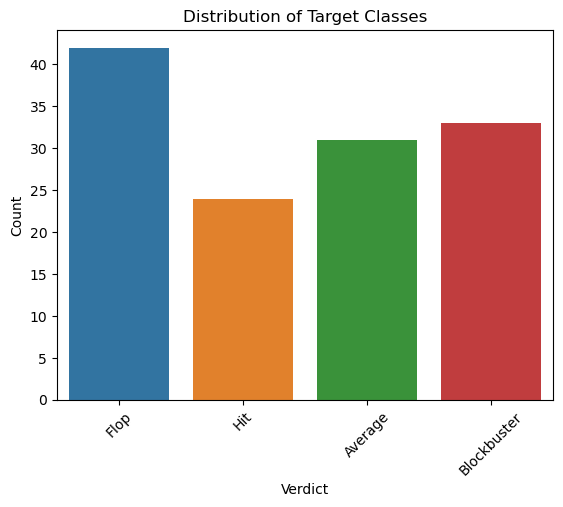

In [77]:
#Target data distribution
import seaborn as sns
sns.countplot(x=y)
plt.title("Distribution of Target Classes")
plt.xlabel("Verdict")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


C:\Users\Krishna\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Krishna\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Krishna\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Krishna\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before o

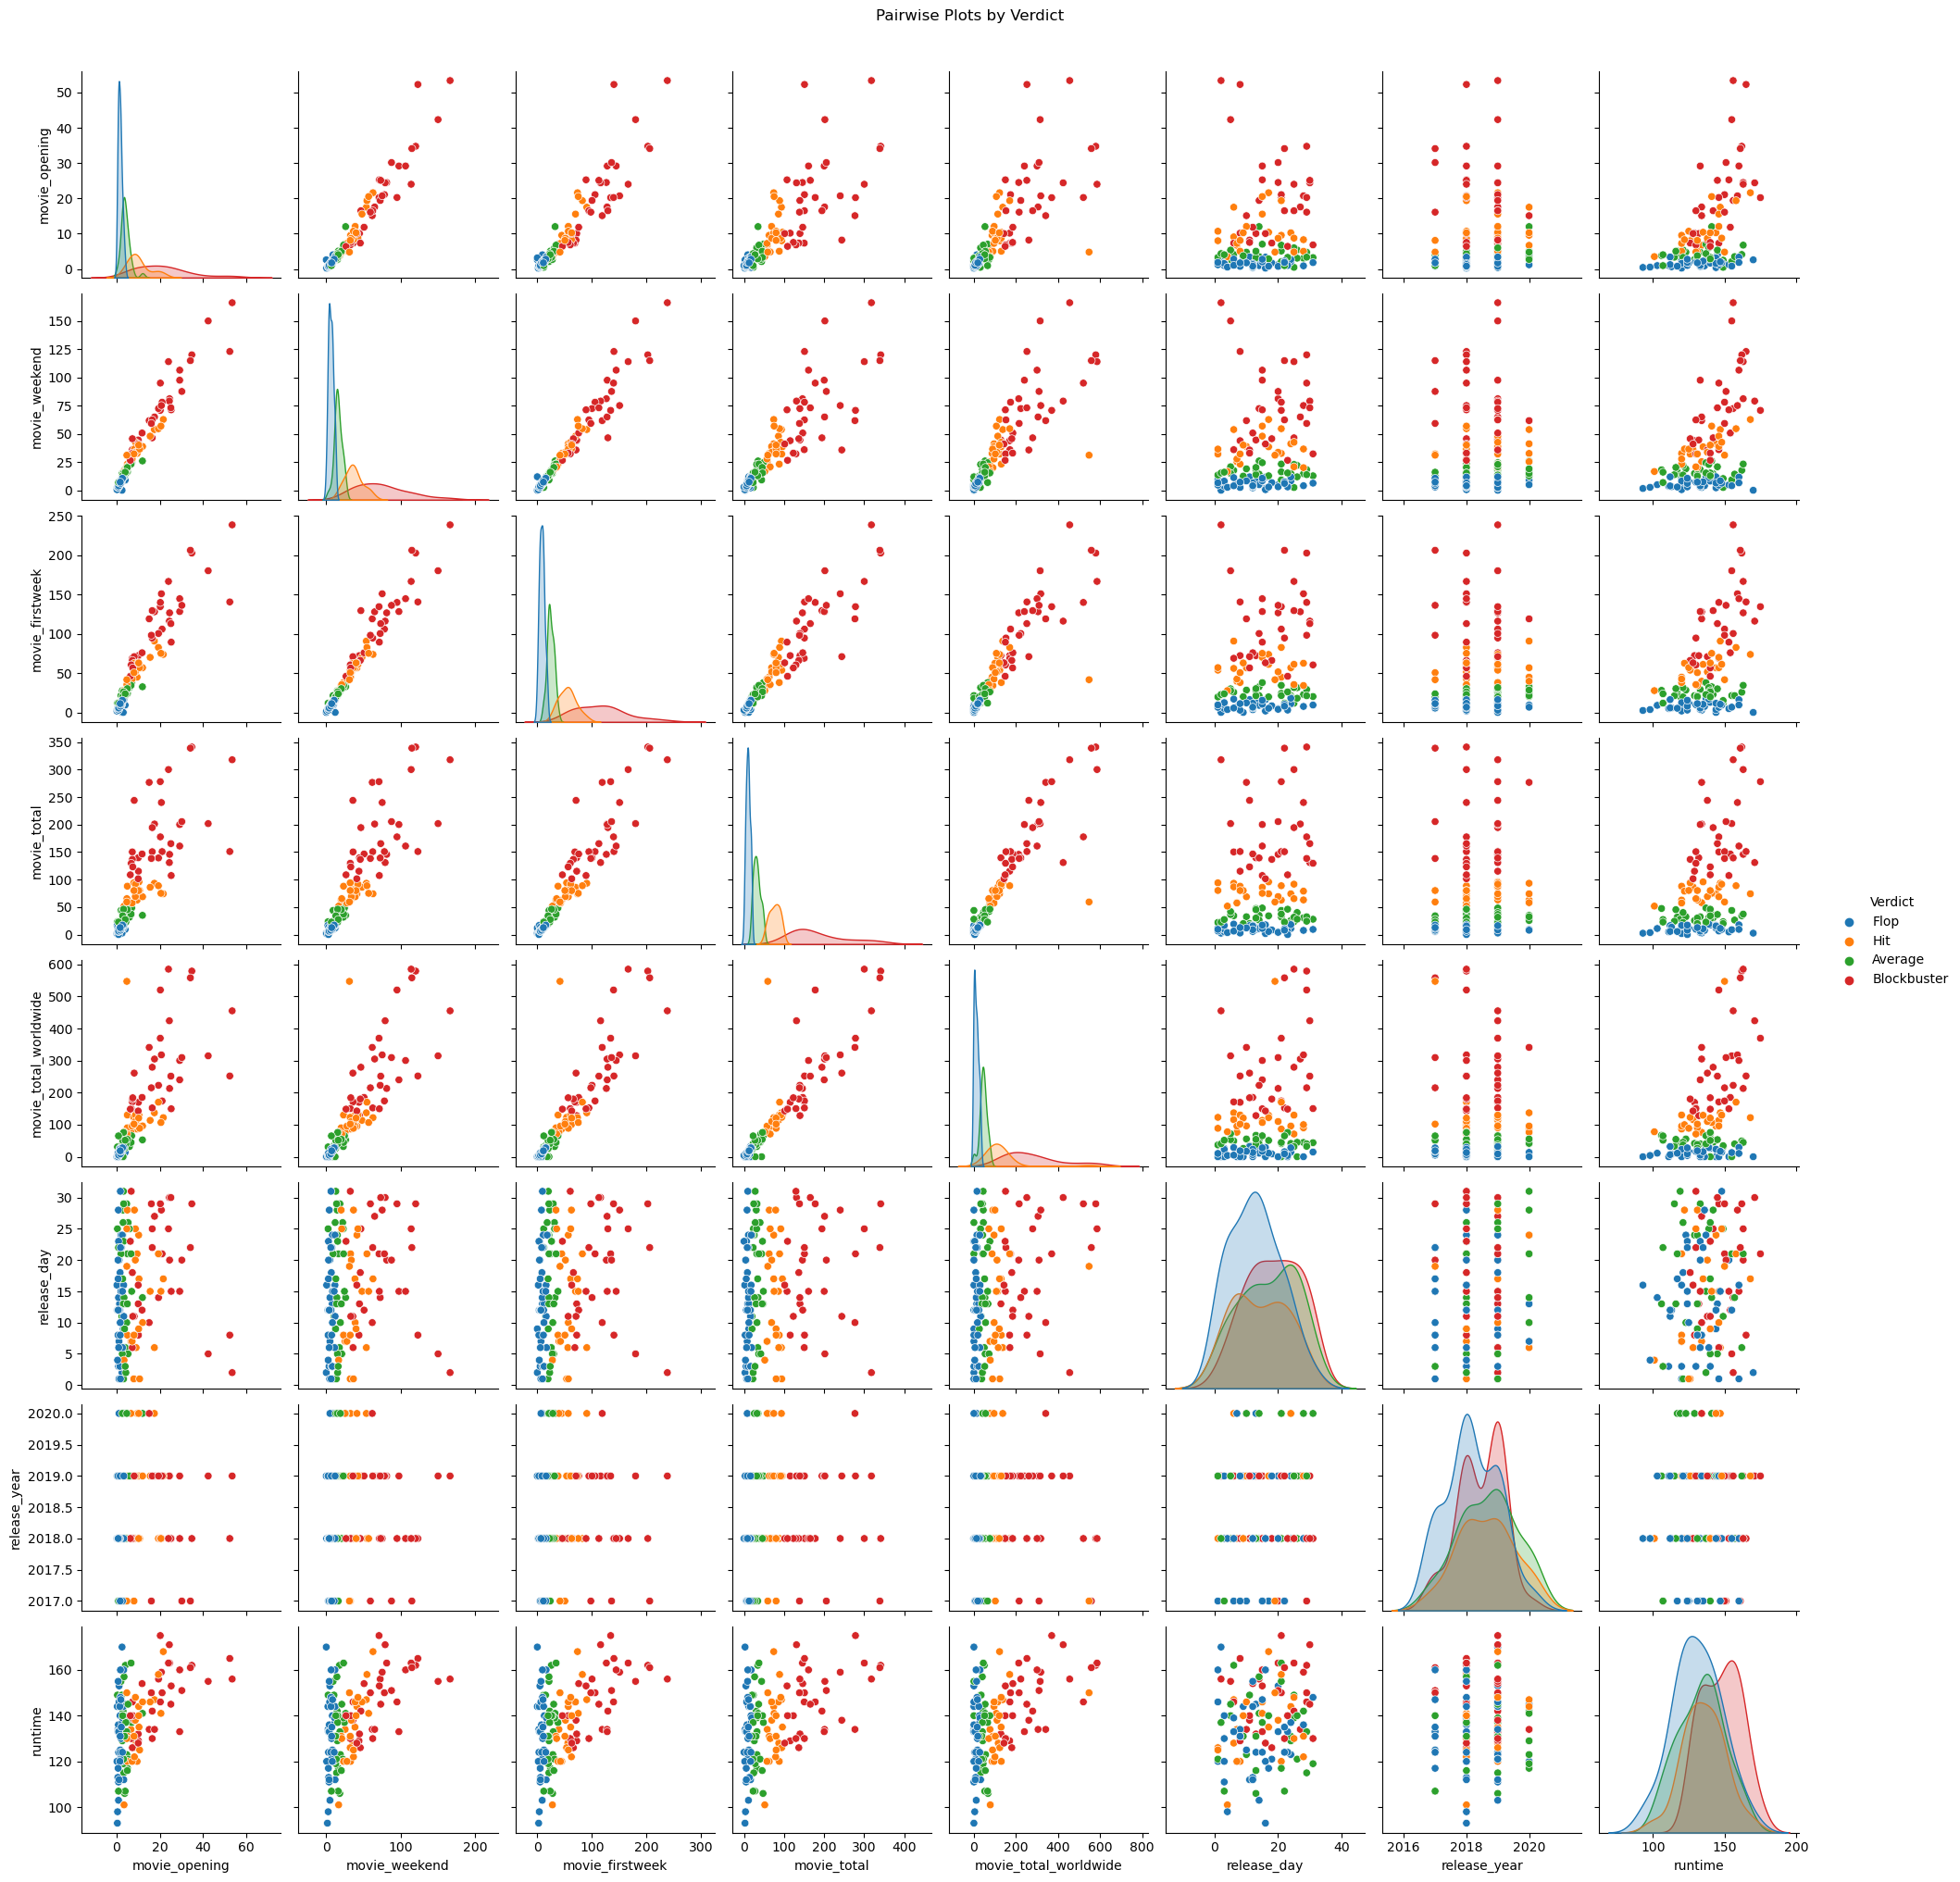

In [76]:
import seaborn as sns

# Add target to the DataFrame temporarily
df_viz = df.copy()
sns.pairplot(df_viz, hue="Verdict", vars=numerical_cols)
plt.suptitle("Pairwise Plots by Verdict", y=1.02)
plt.show()
